In [ ]:
!pip install --upgrade tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Instanciando la red pre-entrenada Xception para aplicarla a la BD con expansión de imágenes pero esta vez con entonación fina

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras import regularizers

from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
conv_base  = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)

83683744/83683744 [==============================] - 4s 0us/step


In [ ]:
!unzip /content/gdrive/MyDrive/TRABAJO/Trabajos_ciencia_de_datos/Clasificacion_imagenes/Dataset_final.zip

Ajustando los datos de la BD


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    'Dataset_final/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
validation_dataset = image_dataset_from_directory(
    'Dataset_final/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
test_dataset = image_dataset_from_directory(
    'Dataset_final/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

Found 1145 files belonging to 4 classes.
Found 488 files belonging to 4 classes.
Found 64 files belonging to 4 classes.


La fase de entrenamiento podrá alterar los pesos de las 4 últimas capas

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                        

Transformaciones para expandir las imágenes y definición de la arquitectura


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.xception.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(768)(x)#, kernel_regularizer=regularizers.l1_l2(0.01))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

Fijar los hiperparámetros y entrenar la red

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

history = model.fit(
    train_dataset,
    epochs=30,  #30
    batch_size=128,
    validation_data=validation_dataset)

Epoch 1/30


36/36 [==============================] - 24s 445ms/step - loss: 1.3510 - accuracy: 0.5223 - val_loss: 1.1502 - val_accuracy: 0.5943
Epoch 2/30
36/36 [==============================] - 17s 425ms/step - loss: 1.0268 - accuracy: 0.6279 - val_loss: 1.0170 - val_accuracy: 0.6168
Epoch 3/30
36/36 [==============================] - 17s 423ms/step - loss: 0.8916 - accuracy: 0.6891 - val_loss: 1.0235 - val_accuracy: 0.6393
Epoch 4/30
36/36 [==============================] - 17s 422ms/step - loss: 0.7912 - accuracy: 0.7004 - val_loss: 1.1318 - val_accuracy: 0.6148
Epoch 5/30
36/36 [==============================] - 19s 499ms/step - loss: 0.7393 - accuracy: 0.7319 - val_loss: 1.1472 - val_accuracy: 0.6230
Epoch 6/30
36/36 [==============================] - 17s 423ms/step - loss: 0.7605 - accuracy: 0.7205 - val_loss: 1.1698 - val_accuracy: 0.6107
Epoch 7/30
36/36 [==============================] - 16s 414ms/step - loss: 0.6457 - accuracy: 0.7712 - val_loss: 1.1073 - val_accuracy: 0.6496
Epoch 8/30

Visualizando la pérdida y el accuracy durante el entrenamiento


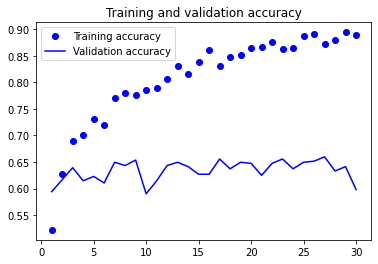

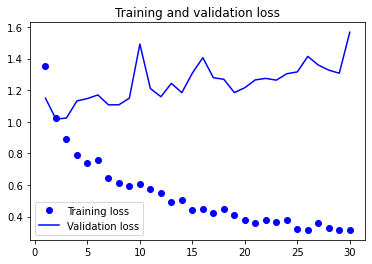

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_dataset)

2/2 [==============================] - 1s 128ms/step - loss: 151.2704 - accuracy: 0.5781


[151.27044677734375, 0.578125]

### Matriz de confusión y métricas relevantes

In [ ]:
import numpy as np

In [ ]:
train_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_train = []  # store predicted labels
labels_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in train_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 147ms/step


In [ ]:
ultimo_label_train = labels_train.pop()
ultima_prediccion_train = predicciones_train.pop()

labels_train = np.array([np.argmax(i, axis = - 1) for i in labels_train]).flatten()
predicciones_train = np.array(predicciones_train).flatten()

ultimo_label_train = np.array([np.argmax(i, axis = - 1) for i in ultimo_label_train]).flatten()
labels_train = np.concatenate((labels_train, ultimo_label_train))
predicciones_train = np.concatenate((predicciones_train, ultima_prediccion_train))

[[218   5   8  33]
 [ 15 213  57  22]
 [ 10  15 178  47]
 [ 13  13  14 284]]


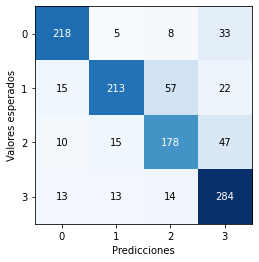

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       264
           1       0.87      0.69      0.77       307
           2       0.69      0.71      0.70       250
           3       0.74      0.88      0.80       324

    accuracy                           0.78      1145
   macro avg       0.79      0.78      0.78      1145
weighted avg       0.79      0.78      0.78      1145



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_train,predicciones_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
fig, ax = plot_confusion_matrix(conf_mat = cf)
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_train,predicciones_train))

In [ ]:
validation_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_val_train = []  # store predicted labels
labels_val_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_val_train.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_val_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 21ms/step


In [ ]:
ultimo_label_val_train = labels_val_train.pop()
ultima_prediccion_val_train = predicciones_val_train.pop()

labels_val_train = np.array([np.argmax(i, axis = - 1) for i in labels_val_train]).flatten()
predicciones_val_train = np.array(predicciones_val_train).flatten()

labels_val_train = np.concatenate((labels_val_train, np.argmax(ultimo_label_val_train, axis = - 1)))
predicciones_val_train = np.concatenate((predicciones_val_train, ultima_prediccion_val_train))

[[ 82   4   3  23]
 [  7  84  21  19]
 [  5  14  70  18]
 [ 20   9   6 103]]


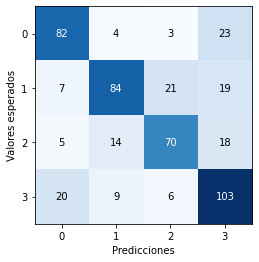

              precision    recall  f1-score   support

           0       0.72      0.73      0.73       112
           1       0.76      0.64      0.69       131
           2       0.70      0.65      0.68       107
           3       0.63      0.75      0.68       138

    accuracy                           0.69       488
   macro avg       0.70      0.69      0.70       488
weighted avg       0.70      0.69      0.69       488



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_val_train,predicciones_val_train)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
fig, ax = plot_confusion_matrix(conf_mat = cf)
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_val_train,predicciones_val_train))

In [ ]:
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
predicciones_test = []  # store predicted labels
labels_test = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_test.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   predicciones_test.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 29ms/step


In [ ]:
labels_test = np.array([np.argmax(i, axis = - 1) for i in labels_test]).flatten()
predicciones_test = np.array(predicciones_test).flatten()

[[11  1  0  4]
 [ 0  4 11  1]
 [ 0  2 13  1]
 [ 3  1  2 10]]


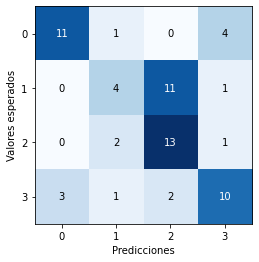

              precision    recall  f1-score   support

           0       0.79      0.69      0.73        16
           1       0.50      0.25      0.33        16
           2       0.50      0.81      0.62        16
           3       0.62      0.62      0.62        16

    accuracy                           0.59        64
   macro avg       0.60      0.59      0.58        64
weighted avg       0.60      0.59      0.58        64



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_test,predicciones_test)
print(cf)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
fig, ax = plot_confusion_matrix(conf_mat = cf)
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_test,predicciones_test))

Guardar el modelo con Tensorflow Lite para correr en Raspberry

In [ ]:
import tensorflow
# Convert the model.
converter = tensorflow.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model_VGG16.tflite', 'wb') as f:
  f.write(tflite_model)